In [4]:
from io import BytesIO
from ipywebrtc import CameraStream, ImageRecorder
import numpy as np
import onnxruntime as rt
from PIL import Image, ImageDraw

In [5]:
camera_config = {
    "facing_mode": "user",
    "audio": False,
    "video": {"width": 416, "height": 416}
}

image_recorder = ImageRecorder(stream=CameraStream(constraints=camera_config))
image_recorder

# TODO: Get image from camera img = Image.open(BytesIO(image_recorder.image.value))

ImageRecorder(image=Image(value=b''), stream=CameraStream(constraints={'facing_mode': 'user', 'audio': False, …

### Read a sample image

The following sample image is taken from the Common Objects in Context (COCO) dataset (test2017/000000068010.jpg). It contains three people in the foreground with additional people in the background. The Python Imaging Library (PIL) reads this image in RGB format with width and height values of 640 and 427 pixels.

![sample](sample.jpg)

The image will be preprocessed by resizing it to the expected model input size of 416 by 416 pixels and using padding to maintain the original aspect ratio. The output looks like:

![preprocessed](sample_preprocessed.jpg)

This notebook will produce an output that looks like the following image:

![preprocessed](sample_predicted.jpg)

In [22]:
#https://github.com/onnx/models/tree/master/vision/object_detection_segmentation/tiny_yolov3
def letterbox_image(image, size):
    '''resize image with unchanged aspect ratio using padding'''
    iw, ih = image.size
    w, h = size
    scale = min(w/iw, h/ih)
    nw = int(iw*scale)
    nh = int(ih*scale)
    # resize image using bicubic interpolation
    image = image.resize((nw,nh), Image.BICUBIC)
    new_image = Image.new('RGB', size, (128,128,128))
    new_image.paste(image, ((w-nw)//2, (h-nh)//2))
    return new_image

def preprocess(img):
    model_image_size = (416, 416)
    boxed_image = letterbox_image(img, tuple(reversed(model_image_size)))
    image_data = np.array(boxed_image, dtype='float32').transpose([2, 0, 1])
    image_data /= 255.
    image_data = np.expand_dims(image_data, 0)
    return image_data

# To use the sample image: img = Image.open("test2017/000000068010.jpg")
img = Image.open(BytesIO(image_recorder.image.value))
image_data = preprocess(img)
image_size = np.array([img.size[1], img.size[0]], dtype=np.float32)[np.newaxis, :]

In [23]:
sess = rt.InferenceSession("yolov3-tiny.onnx")

with open("class_names.txt", "r") as f:
    class_names = [l.strip("\n") for l in f]

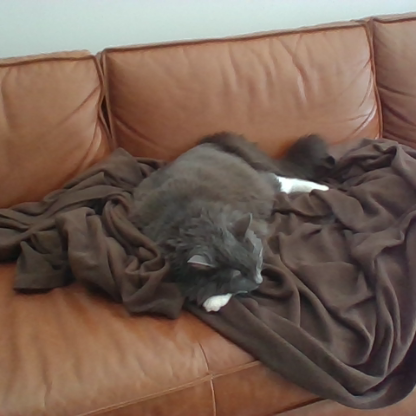

In [24]:
boxes, scores, indices = sess.run(None, {"input_1": image_data, "image_shape": image_size})

out_boxes, out_scores, out_classes = [], [], []
for idx_ in indices[0]:
    out_classes.append(idx_[1])
    out_scores.append(scores[tuple(idx_)])
    idx_1 = (idx_[0], idx_[2])
    out_boxes.append(boxes[idx_1])
    
draw = ImageDraw.Draw(img)
for box, score, class_idx in zip(out_boxes, out_scores, out_classes):
    draw.rectangle(((box[1], box[0]), (box[3], box[2])), outline="yellow")
    draw.text((box[1], box[0]), "{0}, {1:0.2f}%".format(class_names[class_idx], score * 100), fill='yellow')
 
img